<a href="https://colab.research.google.com/github/Pratham-Sri/Deep-Learning/blob/main/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Transfer Learning is leveraging a working model's existing architecture and learned patterns

There are two main benefits:
1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data.

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd

In [ ]:
# get the data
import zipfile

# download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2024-06-23 11:10:49--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 74.125.137.207, 142.250.101.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   126MB/s    in 1.3s    

2024-06-23 11:10:51 (126 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list the number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}.")

There are 2 directories and 0 images in 10_food_classes_10_percent.
There are 10 directories and 0 images in 10_food_classes_10_percent/test.
There are 0 directories and 250 images in 10_food_classes_10_percent/test/ramen.
There are 0 directories and 250 images in 10_food_classes_10_percent/test/hamburger.
There are 0 directories and 250 images in 10_food_classes_10_percent/test/sushi.
There are 0 directories and 250 images in 10_food_classes_10_percent/test/fried_rice.
There are 0 directories and 250 images in 10_food_classes_10_percent/test/grilled_salmon.
There are 0 directories and 250 images in 10_food_classes_10_percent/test/steak.
There are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_curry.
There are 0 directories and 250 images in 10_food_classes_10_percent/test/ice_cream.
There are 0 directories and 250 images in 10_food_classes_10_percent/test/pizza.
There are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_wings.
There are 

### Creating Data Loaders (preparing the data)
We'll use the `ImageDataGenerator` class to load in our images into batches.

In [ ]:
# setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator
IMG_SHAPE = (224,224)
BATCH_SIZE = 32
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMG_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data_10_percent = test_datagen.flow_from_directory(test_dir,
                                               target_size=IMG_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run while our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with Tensorflow callback
* Model checkpoint with ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [ ]:
# Create a TensorBoard callback (functionized because we need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [ ]:
# creating tensorflow models using tensorflowHub
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
from tensorflow.keras import layers

In [ ]:
def create_model(model_url, num_classes=10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer,
      should be equal to the number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained_data and save it as keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the already leanrned patterns
                                           name="feature_extraction_layer",
                                           input_shape=IMG_SHAPE+(3,))

  # Create our own model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation="softmax",name="output_layer")
  ])

  return model

In [ ]:
# Create resnet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [ ]:
# compile our resnet model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [ ]:
# Let's fit our resnet model to the data
resnet_history = resnet_model.fit(train_data_10_percent,
                            epochs=5,
                            steps_per_epoch=len(train_data_10_percent),
                            validation_data=test_data_10_percent,
                            validation_steps=len(test_data_10_percent),
                            callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                  experiment_name="resnet50V2")])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20240623-111059
Epoch 1/5
24/24 [==============================] - 40s 1s/step - loss: 1.8559 - accuracy: 0.4053 - val_loss: 1.1339 - val_accuracy: 0.6424
Epoch 2/5
24/24 [==============================] - 13s 533ms/step - loss: 0.8846 - accuracy: 0.7387 - val_loss: 0.8272 - val_accuracy: 0.7344
Epoch 3/5
24/24 [==============================] - 14s 617ms/step - loss: 0.6143 - accuracy: 0.8333 - val_loss: 0.7518 - val_accuracy: 0.7612
Epoch 4/5
24/24 [==============================] - 25s 1s/step - loss: 0.4767 - accuracy: 0.8747 - val_loss: 0.6975 - val_accuracy: 0.7748
Epoch 5/5
24/24 [==============================] - 12s 497ms/step - loss: 0.3782 - accuracy: 0.9213 - val_loss: 0.6724 - val_accuracy: 0.7780


In [ ]:
# plot the validation and training curves separately
import matplotlib.pyplot as plt
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # plot the loss
  plt.figure(figsize=(5,5))
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('loss')
  plt.xlabel('Epochs')
  plt.legend();

  # plot the accuracy
  plt.figure(figsize=(5,5))
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('accuracy')
  plt.xlabel('Epochs')
  plt.legend();

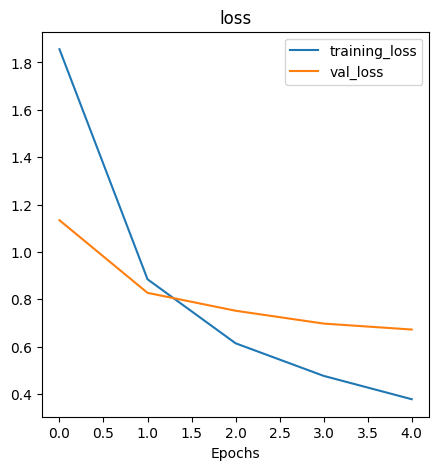

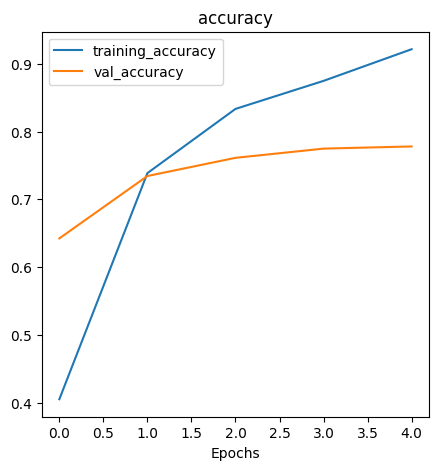

In [ ]:
plot_loss_curves(resnet_history)

### Creating and testing EfficientNetB0 Tensorfflow Hub Feature Extraction Model

In [ ]:
# Create EfficientNetB0 feature extractor model
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes=train_data_10_percent.num_classes)

# compile the model
efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# fit the model
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                             epochs=5,
                                             steps_per_epoch=len(train_data_10_percent),
                                             validation_data=test_data_10_percent,
                                             validation_steps=len(test_data_10_percent),
                                            callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                  experiment_name="efficientnetb0")])


Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20240623-111321
Epoch 1/5
24/24 [==============================] - 37s 917ms/step - loss: 1.8871 - accuracy: 0.4080 - val_loss: 1.3215 - val_accuracy: 0.7336
Epoch 2/5
24/24 [==============================] - 14s 581ms/step - loss: 1.0647 - accuracy: 0.7693 - val_loss: 0.8762 - val_accuracy: 0.8236
Epoch 3/5
24/24 [==============================] - 14s 583ms/step - loss: 0.7607 - accuracy: 0.8347 - val_loss: 0.7023 - val_accuracy: 0.8384
Epoch 4/5
24/24 [==============================] - 13s 576ms/step - loss: 0.6073 - accuracy: 0.8680 - val_loss: 0.6106 - val_accuracy: 0.8524
Epoch 5/5
24/24 [==============================] - 12s 508ms/step - loss: 0.5143 - accuracy: 0.8893 - val_loss: 0.5589 - val_accuracy: 0.8584


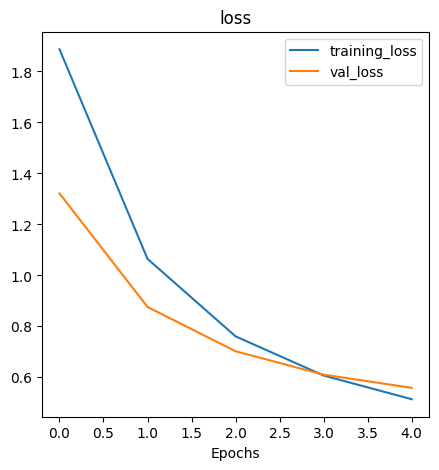

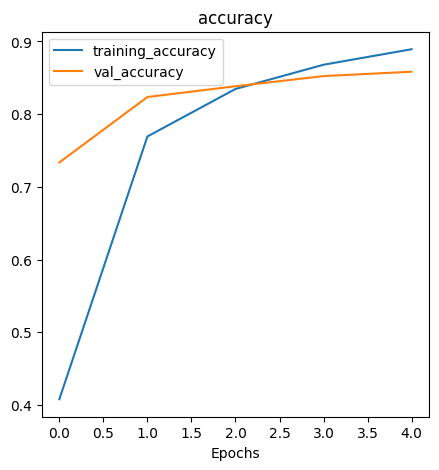

In [ ]:
plot_loss_curves(efficientnet_history)

In [ ]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


## Different types of transfer learning

* "**As is" tranfer learning** - using an exisiting model with no changes of your own (e.g using ImageNet model on 1000 ImageNet images)
* **"Feature Extraction" transfer**  - using the prelearned patterns (EFficientnetB0 trained on ImageNet) and adjust the output layers for your own problem (e.g 1000 classes -> 10 classes of food)
* **"Fine-tuning" transfer learning** - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers)

### Creating helper functions
In previous notebooks, we've created a bunch of helper functions, now we could rewrite them all, however this is tedious.

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-06-23 11:15:07--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2024-06-23 11:15:07 (17.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

### Let's get some data

In [ ]:
# get the 10% data of the training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2024-06-23 11:15:08--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.207, 142.251.2.207, 74.125.137.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   159MB/s    in 1.0s    

2024-06-23 11:15:09 (159 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [ ]:
walk_through_dir("10_food_classes_1_percent")

In [ ]:
# Creating training and test directories paths
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [ ]:
IMG_SIZE = (224,224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE,
                                                                            batch_size=32)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=32)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [ ]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[190.21428   199.21428   170.92857  ]
   [216.35715   224.35715   200.71428  ]
   [222.2449    226.75      208.4643   ]
   ...
   [127.265335  151.26534   137.98471  ]
   [144.18883   168.26027   152.04594  ]
   [146.4642    169.4642    152.29068  ]]

  [[207.16837   214.43367   178.05103  ]
   [223.19388   230.05612   197.34694  ]
   [227.90306   231.94388   205.65816  ]
   ...
   [154.10742   177.80634   167.82162  ]
   [156.36745   180.36745   167.28581  ]
   [171.7041    193.72961   181.58165  ]]

  [[208.92346   213.28061   172.4949   ]
   [206.5153    210.87245   171.08673  ]
   [219.05101   222.40816   187.95918  ]
   ...
   [143.42859   168.52042   164.30618  ]
   [150.33173   172.38785   169.43375  ]
   [157.80602   178.59174   174.44887  ]]

  ...

  [[163.23976   195.09694   201.03065  ]
   [155.78044   187.0101    200.01009  ]
   [163.98944   192.82106   211.32619  ]
   ...
   [171.59166   208.11723   215.82643  ]
   [178.60709   215.60709   224.39282  ]
   [1

In [ ]:
# Create a model with tf.keras.application
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
# Freeze the base model
base_model.trainable = False
# create inputs into our model
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")
# If using ResNet50V2 you will need to normalize inputs
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)
# Pass the inputs to the base_model
x = base_model(inputs)
# Average pool the outputs
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
# Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)
# Combine the inputs with outputs into a model
model_0 = tf.keras.Model(inputs, outputs)
#compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
# fit the model and save its history
history_0 = model_0.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)),
                        callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                               experiment_name="efficientnetb0_10_percent")])

16705208/16705208 [==============================] - 0s 0us/step
Saving TensorBoard log files to: tensorflow_hub/efficientnetb0_10_percent/20240623-111521
Epoch 1/5
24/24 [==============================] - 15s 205ms/step - loss: 1.8698 - accuracy: 0.4307 - val_loss: 1.3030 - val_accuracy: 0.7566
Epoch 2/5
24/24 [==============================] - 5s 166ms/step - loss: 1.0949 - accuracy: 0.7440 - val_loss: 0.8825 - val_accuracy: 0.8092
Epoch 3/5
24/24 [==============================] - 5s 177ms/step - loss: 0.7848 - accuracy: 0.8307 - val_loss: 0.7218 - val_accuracy: 0.8224
Epoch 4/5
24/24 [==============================] - 5s 176ms/step - loss: 0.6494 - accuracy: 0.8520 - val_loss: 0.6288 - val_accuracy: 0.8520
Epoch 5/5
24/24 [==============================] - 5s 176ms/step - loss: 0.5422 - accuracy: 0.8653 - val_loss: 0.5533 - val_accuracy: 0.8618


In [ ]:
model_0.evaluate(test_data)

In [ ]:
# check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

In [ ]:
model_0.summary()

In [ ]:
plot_loss_curves(history_0)

## Getting feature vector from a trained model

Let's demonstrate the Global  Average Pooling 2D layer

We have a tensor after our model goes through `base_model` of shape (None,7,7,1280)...

But when it passes through GlobalAveragePooling2D, it turns into (None,1280).

In [ ]:
#define the input shape
input_shape = (1,4,4,3)

#Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

#Pass the random tensor through a GlobalAveragePooling2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]



In [ ]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

1. `model_1` = use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2` = use feature extractiob transfer learning with 10% of the training data with data augmentation
3. `model_3` = use fine-tuning transfer learning on the 10% of the training data with data augmenetation
4. `model_4` = use fine-tuning transfer learning on 100% of the training data with data augmentation.

In [ ]:
# download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2024-06-23 11:16:07--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 74.125.137.207, 142.250.101.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   113MB/s    in 1.1s    

2024-06-23 11:16:08 (113 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
# create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

In [ ]:
# how many images we workin with?
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'

In [ ]:
# setup data loaders
IMG_SIZE = (224,224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE,
                                                                            batch_size=32)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=32)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## adding data augmentation right into our model
To add data augmentation right into our model, we can use the layers inside:
* `tf.keras.layers.experimental.preprocessing()`

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# create data augmentation stage with horizontal flip, rotations, zooms, etc.
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.Rescale(1./255) # keep for models like ResNet50V2, remove for EfficientNet
], name="data_augmentation")

### Visualize our data augmentation layet

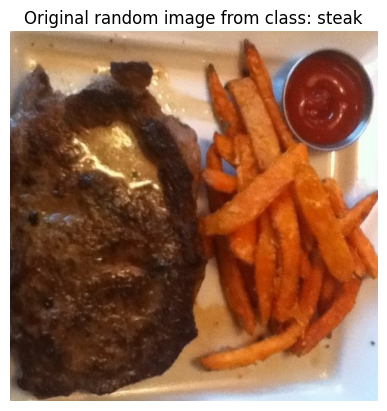

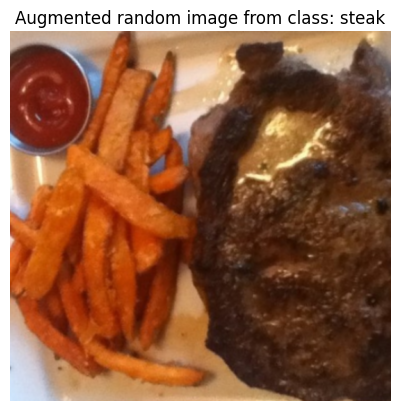

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image
# Read and plot in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False);
# now let's plot our augmented random image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0))
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

In [ ]:
# setup input shape and base model, freezing the base model layers
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# create input layer
input = layers.Input(shape = input_shape,name = 'input_layer')

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10,activation='softmax',name='output_layer')(x)

# make a model using inputs and outputs
model_1 = keras.Model(inputs,outputs)

# compile the model
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# fit the model
history_1_percent = model_1.fit(train_data_1_percent,
            epochs=5,
            steps_per_epoch=len(train_data_1_percent),
            validation_data=test_data,
            validation_steps=int(0.25*(len(test_data))),
            #track model training logs
            callbacks = [create_tensorboard_callback(dir_name='transfer_learning',
                                                    experiment_name='1_percent_data_aug')])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20240623-111615
Epoch 1/5
3/3 [==============================] - 14s 3s/step - loss: 2.3176 - accuracy: 0.1857 - val_loss: 2.1788 - val_accuracy: 0.2303
Epoch 2/5
3/3 [==============================] - 5s 2s/step - loss: 2.0645 - accuracy: 0.3286 - val_loss: 2.0385 - val_accuracy: 0.3026
Epoch 3/5
3/3 [==============================] - 4s 1s/step - loss: 1.8693 - accuracy: 0.4857 - val_loss: 1.9475 - val_accuracy: 0.3487
Epoch 4/5
3/3 [==============================] - 5s 2s/step - loss: 1.7149 - accuracy: 0.5429 - val_loss: 1.8435 - val_accuracy: 0.4145
Epoch 5/5
3/3 [==============================] - 5s 2s/step - loss: 1.5732 - accuracy: 0.6000 - val_loss: 1.7557 - val_accuracy: 0.4622


In [ ]:
model_1.summary()

In [ ]:
model_1.evaluate(test_data)

79/79 [==============================] - 6s 65ms/step - loss: 1.7818 - accuracy: 0.4524


[1.781846523284912, 0.45239999890327454]

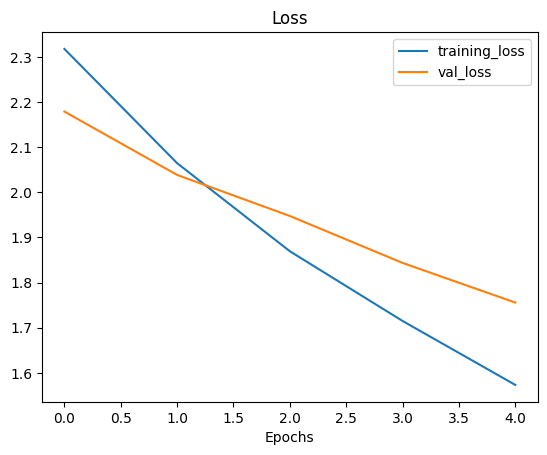

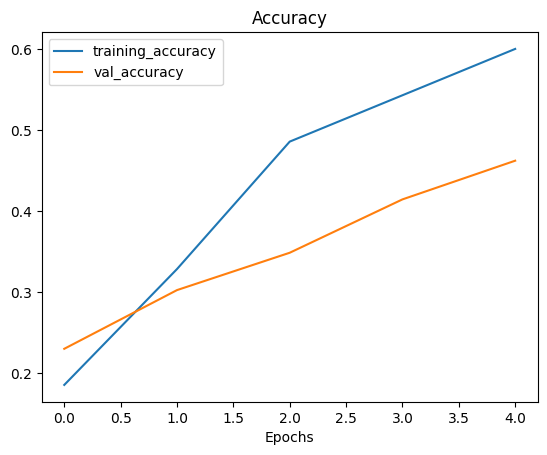

In [ ]:
plot_loss_curves(history_1_percent)

In [ ]:
train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [ ]:
# setup data inputs
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE,
                                                                            batch_size=32)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=32)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# create model_2 with data augmentation built-in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2),
    # preprocessing.Rescale(1./255)
])

# setup the input shape to our model
input_shape = (224,224,3)

# create a model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# create inputs
inputs = layers.Input(shape=input_shape, name="input_layer")

# add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# put in base model
x = base_model(x, training=False)

# average pool the outputs of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# output layer
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# make a model
model_2 = tf.keras.Model(inputs, outputs)

# compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# set checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# create a model checkpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, verbose=1, save_best_only=False , save_weights_only=True, save_freq = "epoch")

In [ ]:
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)),
                                          callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                                                 experiment_name='10_percent_data_aug'),
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20240623-111710
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0429 - accuracy: 0.3080
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 31s 955ms/step - loss: 2.0429 - accuracy: 0.3080 - val_loss: 1.5064 - val_accuracy: 0.6711
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3334 - accuracy: 0.6853
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 21s 848ms/step - loss: 1.3334 - accuracy: 0.6853 - val_loss: 1.0121 - val_accuracy: 0.7944
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0041 - accuracy: 0.7693
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 17s 693ms/step - loss: 1.0041 - accuracy: 0.7693 - val_loss: 0.8220 - val_accuracy: 0.8273
E

In [ ]:
result_10_percent_data_aug = model_2.evaluate(test_data)
result_10_percent_data_aug

In [ ]:
plot_loss_curves(history_10_percent_data_aug)

### Loading in checkpoints
Loading in checkpointed weights returns a model to a specific checkpoint

In [ ]:
# Load in saved model weights returns a model to a specific checkpoint
model_2.load_weights(checkpoint_path)

In [ ]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 6s 68ms/step - loss: 0.6285 - accuracy: 0.8440


In [ ]:
# If the results from our previously evaluated model_2 match the loaded model, everything has worked
result_10_percent_data_aug == loaded_weights_model_results

False

In [ ]:
# check to see if our loaded model results are very close to our previous non - loaded model results
import numpy as np
np.isclose(np.array(result_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [ ]:
# check the difference between two results
print(np.array(result_10_percent_data_aug) - np.array(loaded_weights_model_results))

[1.78813934e-07 0.00000000e+00]


### Model_3 : Fine Tuning an existing model on 10% of the data
> Fine tuning usually works best after training a feature extraction model on loads of data for few epochs

In [ ]:
model_2.layers

In [ ]:
for layer in model_2.layers:
  print(layer,layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x7ce5b46cba90> True
<keras.src.engine.sequential.Sequential object at 0x7ce254da04f0> True
<keras.src.engine.functional.Functional object at 0x7ce254d5f370> False
<keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7ce2556955d0> True
<keras.src.layers.core.dense.Dense object at 0x7ce254d5ead0> True


In [ ]:
# What layers are in our base model (EfficientNetB0)
for i, layer in enumerate(base_model.layers):
  print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [ ]:
# how many trainable model's in our base model?
print(len(model_2.layers[2].trainable_variables))

0


In [ ]:
# to begin fine tunning let's start by setting the last 10 layers of your base_model.trainable = false
base_model.trainable = True

# Freeze all layers execept for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile (we have to recompile our model everytime we make a change)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # when fine tuning lower the lr to avoid overfitting and retain the patterns learned
                metrics=["accuracy"])

In [ ]:
print(len(model_2.trainable_variables))

12


In [ ]:
# fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# refit the model(same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               validation_steps=int(0.25 * len(test_data)),
                                               initial_epoch=history_10_percent_data_aug.epoch[-1],
                                               callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                     experiment_name="10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20240623-111917
Epoch 5/10
24/24 [==============================] - ETA: 0s - loss: 0.6294 - accuracy: 0.8347

In [ ]:
results_fine_tune_10_percent = model_2.evaluate(test_data)

In [ ]:
plot_loss_curves(history_fine_10_percent_data_aug)

In [ ]:
# let's create a function to compare the model before and after fine tuning the model
def compare_history(original_history, new_history, initial_epochs=5):
  """
  Compares two model history objects.
  """
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = new_history.history["val_accuracy"]
  val_loss = new_history.history["val_loss"]

  # combine original history
  total_acc = acc + new_history.history['accuracy']
  total_loss = loss + new_history.history['loss']

  total_val_acc = val_acc + new_history.history['val_accuracy']
  total_val_loss = val_loss + new_history.history['val_loss']

  # make plots for accuracy
  plt.figure(figsize=(8,8))
  plt.subplot(2,1,1)
  plt.plot(total_acc, label='Training Accuracy')
  plt.plot(total_val_acc, label='Validation Accuracy')
  plt.plot([initial_epochs-1, initial_epochs-1],
           plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epochs')

  # make plots for loss
  plt.figure(figsize=(8,8))
  plt.subplot(2,1,1)
  plt.plot(total_loss, label='Training Loss')
  plt.plot(total_val_loss, label='Validation Loss')
  plt.plot([initial_epochs-1, initial_epochs-1],
           plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.ylabel('Accuracy')
  plt.xlabel('Epochs')


In [ ]:
compare_history(history_10_percent_data_aug, history_fine_10_percent_data_aug, initial_epochs=5)

### Model_4 : Fine tuning on 100% data with fine tuning

In [ ]:
# Download and unzip 10 classes of Food101 data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

In [ ]:
# setup training and test dirs
train_dir_all_data = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

In [ ]:
walk_through_dir("10_food_classes_all_data")

In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)